<a href="https://colab.research.google.com/github/DanielTaylor97/HonoursProject/blob/master/projectCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Honours Project CNN
## Probably only for use in the actual heatmaps -- the network will be trained on my desktop :)

### IMPORTS

In [0]:
from __future__ import division, absolute_import, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import PIL, PIL.Image
from scipy import signal
import time

from sklearn.model_selection import train_test_split

### MORE IMPORTS, AND ACCESSING DRIVE

In [0]:
import pandas as pd

#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files, drive
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
GDrive = GoogleDrive(gauth)

### READ .NPY GM FILE FROM DRIVE

In [0]:
#id = '1bFXPJlSsIKomQ4yUqFkcfS7xzEp07RBH'
#downloaded = GDrive.CreateFile({'id':id}) 
#downloaded.GetContentFile('even_wm.npy')
#wm = np.load('even_wm.npy')

id = '1QQj4cK7fDvhctRPlJ2lKc9EdHSF9cRQn'
downloaded = GDrive.CreateFile({'id':id}) 
downloaded.GetContentFile('even_gm_images.npy')
gm = np.load('even_gm_images.npy')

### READ .NPY AGES FILES FROM DRIVE

In [4]:
#id = '1iBQSb_dClm-mJ4lV70da4HPgJK9RuNPw'
#downloaded = GDrive.CreateFile({'id':id}) 
#downloaded.GetContentFile('even_ages.npy')  
#ages = np.load('even_ages.npy')

id = '1LyWSo2X7YrjbHCFCjvg5ghtwj5XSsVM-'
downloaded = GDrive.CreateFile({'id':id}) 
downloaded.GetContentFile('even_gm_ages.npy')  
ages = np.load('even_gm_ages.npy')

ages

array([60.    , 59.51  , 19.    , 21.    , 28.    , 21.    , 62.    ,
       81.    , 37.    , 32.42  , 49.02  , 24.34  , 40.04  , 24.6352,
       51.    , 19.    , 18.    , 17.    , 85.74  , 45.39  , 19.    ,
       66.28  , 37.    , 33.92  , 43.    , 21.    , 24.    , 49.4   ,
       59.15  , 39.    , 31.    , 34.    , 18.    , 22.    , 25.    ,
       21.    , 25.    , 22.    , 30.    , 83.46  , 29.    , 23.    ,
       19.    , 54.19  , 54.74  , 82.    , 50.    , 20.    , 24.    ,
       31.81  , 55.09  , 25.93  , 24.    , 30.7   , 19.    , 69.    ,
       69.69  , 45.    , 27.    , 19.    , 70.56  , 21.    , 63.1   ,
       19.    , 36.    , 22.    , 37.    , 31.    , 25.    , 21.    ,
       30.    , 35.    , 28.    , 39.    , 18.    , 20.    , 64.    ,
       34.24  , 24.    , 21.    , 57.    , 22.    , 72.09  , 23.    ,
       77.    , 58.    , 21.    , 26.88  , 22.    , 26.    , 90.    ,
       21.    , 19.    , 25.    , 26.    , 41.9   , 27.    , 74.    ,
       21.    , 44. 

### BATCH THE AGE DATA

In [5]:
ages = np.floor((ages - 10)/30)
#ages.shape #(342,)
ages
#wm.shape #(342, 100, 124, 104, 1)

array([1., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 2., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 2., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 2., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 2., 0., 2.,
       1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 2., 0., 0., 0., 1., 1., 1., 0., 2., 0., 0., 0., 1., 1.,
       2., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 2., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 2., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1.,
       2., 1., 1., 1., 1.

### MODEL DEFINITION

In [0]:
def create_model():
  model = tf.keras.models.Sequential([
      layers.Conv3D(8, (3, 3, 3), activation = 'relu', input_shape = (100, 124, 104, 1), name = 'Conv3d_1a'),
      layers.Conv3D(8, (3, 3, 3), name = 'Conv3d_1b'),
      layers.BatchNormalization(name = 'BatchNorm_1'),
      layers.ReLU(name = 'Relu_1'),
      layers.AveragePooling3D((2, 2, 2), name = 'AvePool_1'),
      layers.Conv3D(16, (3, 3, 3), activation = 'relu', name = 'Conv3d_2a'),
      layers.Conv3D(16, (3, 3, 3), name = 'Conv3d_2b'),
      layers.BatchNormalization(name = 'BatchNorm_2'),
      layers.ReLU(name = 'Relu_2'),
      layers.AveragePooling3D((2, 2, 2), name = 'AvePool_2'),
      layers.Conv3D(32, (3, 3, 3), activation = 'relu', name = 'Conv3d_3a'),
      layers.Conv3D(32, (3, 3, 3), name = 'Conv3d_3b'),
      layers.BatchNormalization(name = 'BatchNorm_3'),
      layers.ReLU(name = 'Relu_3'),
      layers.AveragePooling3D((2, 2, 2), name = 'AvePool_3'),
      layers.Conv3D(64, (3, 3, 3), activation = 'relu', name = 'Conv3d_4a'),
      layers.Conv3D(64, (3, 3, 3), name = 'Conv3d_4b'),
      layers.BatchNormalization(name = 'BatchNorm_4'),
      layers.ReLU(name = 'Relu_4'),
      layers.AveragePooling3D((2, 2, 2), name = 'AvePool_4'),
      #layers.Conv3D(128, (3, 3, 3), activation = 'relu', name = 'Conv3d_5a'),
      #layers.Conv3D(128, (3, 3, 3), name = 'Conv3d_5b'),
      #layers.BatchNormalization(name = 'BatchNorm_5'),
      #layers.ReLU(name = 'Relu_5'),
      #layers.AveragePooling3D((2, 2, 2), name = 'AvePool_5'),
      layers.Flatten(name = 'flatten'),
      layers.Dense(32, activation = 'relu', name = 'dense_1'),
      layers.Dense(3, activation = 'softmax', name = 'dense_2')
  ])
  
  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  #model.compile(optimizer='rmsprop',
  #              loss='MAE',
  #              metrics=['MAE'])
      
  return model

### LOAD MODEL FROM DRIVE

In [0]:
#id = '1hSl43yCtXX5bT-yHVEAetReyhdaaS6bZ'
#downloaded = GDrive.CreateFile({'id':id}) 
#downloaded.GetContentFile('model_1.h5')  
#model_1 = models.load_model('model_1.h5')

id = '1ytvpOKi0felWUMiB5BXhxGqblpJSKy2g'
downloaded = GDrive.CreateFile({'id':id}) 
downloaded.GetContentFile('model_2.h5')  
model_1 = models.load_model('model_2.h5')

In [7]:
#model_1 = create_model()
#model_1 = models.load_model('model_1.h5')
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3d_1a (Conv3D)           (None, 98, 122, 102, 8)   224       
_________________________________________________________________
Conv3d_1b (Conv3D)           (None, 96, 120, 100, 8)   1736      
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 96, 120, 100, 8)   32        
_________________________________________________________________
Relu_1 (ReLU)                (None, 96, 120, 100, 8)   0         
_________________________________________________________________
AvePool_1 (AveragePooling3D) (None, 48, 60, 50, 8)     0         
_________________________________________________________________
Conv3d_2a (Conv3D)           (None, 46, 58, 48, 16)    3472      
_________________________________________________________________
Conv3d_2b (Conv3D)           (None, 44, 56, 46, 16)    6

### EXTRACT THE NETWORK PARAMETERS

In [0]:
#Input image is 1*100*124*104*1 image
W_Conv_1a = np.asarray(model_1.get_weights()[0])  #3*3*3*1*8 array of weights   --> takes input to 98*122*102*8 tensor
W_Conv_1b = np.asarray(model_1.get_weights()[2])  #3*3*3*8*8 array of weights   --> takes input to 96*120*100*8 tensor
W_Conv_2a = np.asarray(model_1.get_weights()[8])  #3*3*3*8*16 array of weights  --> takes input to 46*58*48*16 tensor
W_Conv_2b = np.asarray(model_1.get_weights()[10]) #3*3*3*16*16 array of weights --> takes input to 44*56*46*16 tensor
W_Conv_3a = np.asarray(model_1.get_weights()[16]) #3*3*3*16*32 array of weights --> takes input to 20*26*21*32 tensor
W_Conv_3b = np.asarray(model_1.get_weights()[18]) #3*3*3*32*32 array of weights --> takes input to 18*24*19*32 tensor
W_Conv_4a = np.asarray(model_1.get_weights()[24]) #3*3*3*32*64 array of weights --> takes input to 7*10*7*64 tensor
W_Conv_4b = np.asarray(model_1.get_weights()[26]) #3*3*3*64*64 array of weights --> takes input to 5*8*5*64 tensor

B_Conv_1a = np.asarray(model_1.get_weights()[1])  #array of 8 biases
B_Conv_1b = np.asarray(model_1.get_weights()[3])  #array of 8 biases
B_Conv_2a = np.asarray(model_1.get_weights()[9])  #array of 16 biases
B_Conv_2b = np.asarray(model_1.get_weights()[11]) #array of 16 biases
B_Conv_3a = np.asarray(model_1.get_weights()[17]) #array of 32 biases
B_Conv_3b = np.asarray(model_1.get_weights()[19]) #array of 32 biases
B_Conv_4a = np.asarray(model_1.get_weights()[25]) #array of 64 biases
B_Conv_4b = np.asarray(model_1.get_weights()[27]) #array of 64 biases

gamma_1 = np.asarray(model_1.get_weights()[4]) #8 gammas
beta_1 = np.asarray(model_1.get_weights()[5]) #8 betas
mean_1 = np.asarray(model_1.get_weights()[6]) #8 means
var_1 = np.asarray(model_1.get_weights()[7]) #8 variances

gamma_2 = np.asarray(model_1.get_weights()[12]) #16 gammas
beta_2 = np.asarray(model_1.get_weights()[13]) #16 betas
mean_2 = np.asarray(model_1.get_weights()[14]) #16 means
var_2 = np.asarray(model_1.get_weights()[15]) #16 variances

gamma_3 = np.asarray(model_1.get_weights()[20]) #32 gammas
beta_3 = np.asarray(model_1.get_weights()[21]) #32 betas
mean_3 = np.asarray(model_1.get_weights()[22]) #32 means
var_3 = np.asarray(model_1.get_weights()[23]) #32 variances

gamma_4 = np.asarray(model_1.get_weights()[28]) #64 gammas
beta_4 = np.asarray(model_1.get_weights()[29]) #64 betas
mean_4 = np.asarray(model_1.get_weights()[30]) #64 means
var_4 = np.asarray(model_1.get_weights()[31]) #64 variances

W_Dense_1 = np.asarray(model_1.get_weights()[32]) #1024*32 array of weights --> takes 1024 flattened tensor to 32 activations (dense)
W_Dense_2 = np.asarray(model_1.get_weights()[34]) #32*3 array of weights --> takes 32 activations from previous layer to 3 activations (dense)

B_Dense_1 = np.asarray(model_1.get_weights()[33]) #array of 32 biases
B_Dense_2 = np.asarray(model_1.get_weights()[35]) #array of 3 biases

LAYERS STRUCTURE

In [0]:
#1.    3*3*3 convolution window: takes 100*124*104*1 image to 98*122*102*8 tensor  -- W_Conv_1a, B_Conv_1a
#2.    3*3*3 convolution window: takes 98*122*102*8 tensor to 96*120*100*8 tensor  -- W_Conv_1b, B_Conv_1b
#3.    batchnorm normalisation: no shape change                                    -- gamma_BatchNorm_1, beta_BatchNorm_1, mean_BatchNorm_1, var_BatchNorm_1
#4.    ReLU activation: no shape change
#5.    2*2*2 avePooling layer: takes 96*120*100*8 tensor to 48*60*50*8 tensor

#6.    3*3*3 convolution window: takes 48*60*50*8 tensor to 46*58*48*16 tensor     -- W_Conv_2a, B_Conv_2a
#7.    3*3*3 convolution window: takes 46*58*48*16 tensor to 44*56*46*16 tensor    -- W_Conv_2b, B_Conv_2b
#8.    batchnorm normalisation: no shape change                                    -- gamma_BatchNorm_2, beta_BatchNorm_2, mean_BatchNorm_2, var_BatchNorm_2
#9.    ReLU activation: no shape change
#10.   2*2*2 avePooling layer: takes 44*56*46*16 tensor to 22*28*23*16 tensor

#11.   3*3*3 convolution window: takes 22*28*23*16 tensor to 20*26*21*32 tensor    -- W_Conv_3a, B_Conv_3a
#12.   3*3*3 convolution window: takes 20*26*21*32 tensor to 18*24*19*32 tensor    -- W_Conv_3b, B_Conv_3b
#13.   batchnorm normalisation: no shape change                                    -- gamma_BatchNorm_3, beta_BatchNorm_3, mean_BatchNorm_3, var_BatchNorm_3
#14.   ReLU activation: no shape change
#15.   2*2*2 avePooling layer: takes 18*24*19*32 tensor to 9*12*9*32 tensor

#16.   3*3*3 convolution window: takes 9*12*9*32 tensor to 7*10*7*64 tensor        -- W_Conv_4a, B_Conv_4a
#17.   3*3*3 convolution window: takes 7*10*7*64 tensor to 5*8*5*64 tensor         -- W_Conv_4b, B_Conv_4b
#18.   batchnorm normalisation: no shape change                                    -- gamma_BatchNorm_4, beta_BatchNorm_4, mean_BatchNorm_4, var_BatchNorm_4
#19.   ReLU activation: no shape change
#20.   2*2*2 avePooling layer: takes 5*8*5*64 tensor to 2*4*2*64 tensor

#21.   Flattening layer: takes 2*4*2*64 tensor to 1024 tensor
#22.   Fully-connected layer: 32 neurons, ReLU activation                          -- W_Dense_1, B_Dense_1
#23.   Fully-connected layer: 3 neurons, Softmax activation                        -- W_Dense_2, B_Dense_2

### EXAMINE PARTS OF THE MRI DATA

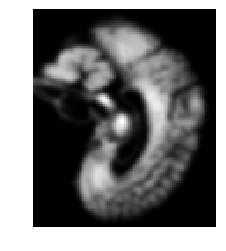

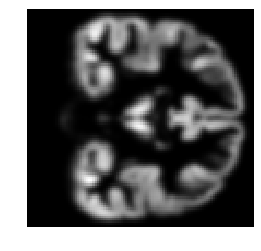

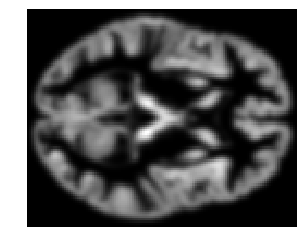

In [75]:
subject = 58 #np.random.randint(0, 324)     #Somewhere between 0 and 341
width = 49                              #Somewhere between 0 and 99
depth = 60                              #Somewhere between 0 and 123
height = 50                             #Somewhere between 0 and 103
#Image dimensions are (342, 100, 124, 104, 1)

plt.imshow(gm[subject, width, :, :, 0], cmap = 'gray')
plt.axis('off')
plt.savefig('MRI_ex1')
plt.show()

plt.imshow(gm[subject, :, depth, :, 0], cmap = 'gray')
plt.axis('off')
plt.savefig('MRI_ex2')
plt.show()

plt.imshow(gm[subject, :, :, height, 0], cmap = 'gray')
plt.axis('off')
plt.savefig('MRI_ex3')
plt.show()

#subject

In [0]:
#files.download('MRI_ex1.png')
#files.download('MRI_ex2.png')
#files.download('MRI_ex3.png')

### TRAIN MODEL

In [0]:
gm_train, gm_test, ages_train, ages_test = train_test_split(
  gm, ages, train_size = 0.08, test_size = 0.02, shuffle = True)

EPOCHS = 1

history = model_1.fit(gm_train, ages_train, epochs = EPOCHS,
            batch_size=3, validation_data=(gm_test, ages_test), verbose=1)

model_1.save('model_1.h5')

### MAKE SOME PREDICTIONS

RANDOM SAMPLES

In [0]:
N = 50
random_patients = np.random.randint(0, 342, N)
random_ages = np.zeros(N)
random_gm = np.zeros(N*100*124*104)#(N, 100, 124, 104, 1)
random_gm = random_gm.reshape(N, 100, 124, 104, 1)
j = 0

for i in range(0, N):
  j = random_patients[i]
  random_ages[i] = ages[j]
  random_gm[i, :, :, :, :] = gm[j, :, :, :, :]

ONLY ELDERLY SAMPLES

In [0]:
N = 114 #up to 114
oldbois = 2*np.ones(N)
old_gm = np.zeros(N*100*124*104)#(N, 100, 124, 104, 1)
old_gm = old_gm.reshape(N, 100, 124, 104, 1)
j = 0
a = 0

for i in range(0, 342):
  a = ages[i]
  if a == 2:
    old_gm[j, :, :, :, :] = gm[i, :, :, :, :]
    j += 1
  if j >= N:
    break

ONLY YOUNG SAMPLES

In [0]:
N = 114 #up to 114
youngbois = np.zeros(N)
young_gm = np.zeros(N*100*124*104)#(N, 100, 124, 104, 1)
young_gm = young_gm.reshape(N, 100, 124, 104, 1)
j = 0
a = 0

for i in range(0, 342):
  a = ages[i]
  if a == 0:
    young_gm[j, :, :, :, :] = gm[i, :, :, :, :]
    j += 1
  if j >= N:
    break

ONLY MIDDLE-AGED SAMPLES

In [0]:
N = 114 #up to 114
midbois = 1*np.ones(N)
mid_gm = np.zeros(N*100*124*104)#(N, 100, 124, 104, 1)
mid_gm = mid_gm.reshape(N, 100, 124, 104, 1)
j = 0
a = 0

for i in range(0, 342):
  a = ages[i]
  if a == 1:
    mid_gm[j, :, :, :, :] = gm[i, :, :, :, :]
    j += 1
  if j >= N:
    break

RANDOM RESULTS

In [0]:
results = model_1.evaluate(random_gm, random_ages)
print('loss, accuracy: {}'.format(results)) #0.72222

50/50 [==============================] - 55s 1s/sample - loss: 0.4025 - acc: 0.8200
loss, accuracy: [0.40246675789356234, 0.82]


YOUNG ONLY RESULTS

In [0]:
results = model_1.evaluate(young_gm, youngbois)
print('loss, accuracy: {}'.format(results)) #0.81578946

114/114 [==============================] - 122s 1s/sample - loss: 0.5138 - acc: 0.8158
loss, accuracy: [0.5138063990233237, 0.81578946]


MID ONLY RESULTS

In [0]:
results = model_1.evaluate(mid_gm, midbois)
#results = model_1.evaluate(mid_gm, oldbois) #0.49122807
print('loss, accuracy: {}'.format(results)) #0.3508772

114/114 [==============================] - 124s 1s/sample - loss: 1.4446 - acc: 0.4912
loss, accuracy: [1.4445636523397345, 0.49122807]


OLD ONLY RESULTS

In [0]:
results = model_1.evaluate(old_gm, oldbois)
print('loss, accuracy: {}'.format(results)) #1.0

114/114 [==============================] - 121s 1s/sample - loss: 0.0486 - acc: 1.0000
loss, accuracy: [0.04857893961302021, 1.0]


### EXAMINE MRI DATA FROM EACH GROUP

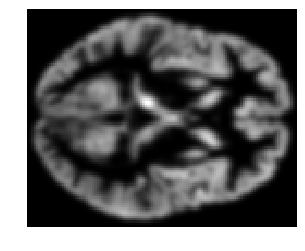

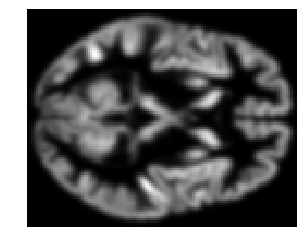

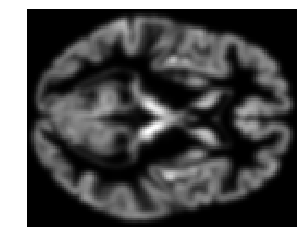

In [0]:
subject = 90 #Somewhere between 0 and 113
height = 50 #Somewhere between 0 and 103
depth = 60 #Somewhere between 0 and 123
width = 50 #Somewhere between 0 and 99
#Image dimensions are (342, 100, 124, 104, 1)

plt.imshow(young_gm[subject, :, :, height, 0]/np.max(young_gm[subject, :, :, height, 0]), cmap = 'gray')
plt.axis('off')
plt.show()
plt.imshow(mid_gm[subject, :, :, height, 0]/np.max(mid_gm[subject, :, :, height, 0]), cmap = 'gray')
plt.axis('off')
plt.show()
plt.imshow(old_gm[subject, :, :, height, 0]/np.max(old_gm[subject, :, :, height, 0]), cmap = 'gray')
plt.axis('off')
plt.show()
#Each image normalised to have the brightest pixel value be 1

### HEATMAP FUNCTIONS

In [0]:
lowest = -4.0
highest = 4.0

#########################
##DENSE LAYER FUNCTIONS##
#########################

def forward_first(X, W, B):
  return np.matmul(X, W) + B

def relprop_first(X, W, R):
  V = np.maximum(0, W)
  U = np.minimum(0, W)
  L = X*0 + lowest  #vector of the same number -- lower bound
  H = X*0 + highest #vector of the same number -- upper bound
  
  Z = np.matmul(X, W) - np.matmul(L, V) - np.matmul(H, U) + 1e-9
  S = R/Z
  R = X*np.dot(S, W.T) - L*np.dot(S, V.T) - H*np.dot(S, U.T)
  return R
  
def forward_next(X, W, B):
  return np.matmul(X, W) + B

#z^+ rule
def relprop_next(X, W, R):
  V = np.maximum(0, W)
  Z = np.matmul(X, V) + 1e-9 #we divide by this later -- no division by zero!
  S = R/Z
  C = np.dot(S, V.T)
  R = X*C
  return R
  
def forward_relu(X):
  Z = X>0
  return X*Z

def relprop_relu(R):
  return R


#########################
##CONVOLUTION FUNCTIONS##
#########################

def forward_conv(X, V, B): #(activations a.c.l., weights f.h.l., biases f.h.l.)
  mb, wx, hx, dx, nx = X.shape
  ww, hw, dw, nx, ny = V.shape
  
  wy = wx - ww + 1
  hy = hx - hw + 1
  dy = dx - dw + 1
  
  Y = np.zeros([mb, wy, hy, dy, ny], dtype = 'float32')
  
  for i in range(ww):
    for j in range(hw):
      for k in range(dw):
        Y += np.dot(X[:, i:(i + wy), j:(j + hy), k:(k + dy), :], V[i, j, k, :, :])
      
  return Y + B

def gradprop_conv(X, W, DY):
  mb, wy, hy, dy, ny = DY.shape
  ww, hw, dw, nx, ny = W.shape
  
  DX = X*0
  
  for i in range(ww):
    for j in range(hw):
      for k in range(dw):
        DX[:, i:(i + wy), j:(j + hy), k:(k + dy), :] += np.dot(DY, W[i, j, k, :, :].T)
      
  return DX

#z^+ rule
def relprop_nextconv(X, W, R): #(activations a.h.l., weights f.h.l., relevance a.c.l.)
  V = np.maximum(0, W)
  Z = forward_conv(X, V, 0) + 1e-9
  S = R/Z
  C = gradprop_conv(X, V, S)#changed W->V
  R = X*C
  return R

def relprop_firstconv(X, W, R):
  V = np.maximum(0, W)
  U = np.minimum(0, W)
  
  L = X*0 + lowest
  H = X*0 + highest
  
  Z = forward_conv(X, W, R) - forward_conv(L, V, R) - forward_conv(H, U, R) + 1e-9
  
  S = R/Z
  R = X*gradprop_conv(X, W, S) - L*gradprop_conv(L, V, S) - H*gradprop_conv(H, U, S)
  return R


#####################
##POOLING FUNCTIONS##
#####################

def forward_pooling(X):
  x = int(2*np.floor(X.shape[1]/2.0))
  y = int(2*np.floor(X.shape[2]/2.0))
  z = int(2*np.floor(X.shape[3]/2.0))
  
  Y = (X[:, :x:2 ,:y:2 , :z:2 ,:] + X[: ,:x:2 ,1:y:2, :z:2, :] + X[:, 1:x:2, :y:2, :z:2, :] + X[:, 1:x:2, 1:y:2, :z:2, :]
      + X[:, :x:2 ,:y:2 , 1:z:2 ,:] + X[: ,:x:2 ,1:y:2, 1:z:2, :] + X[:, 1:x:2, :y:2, 1:z:2, :] + X[:, 1:x:2, 1:y:2, 1:z:2, :])/8
  return Y

def gradprop_pooling(X, DY):
  x = int(2*np.floor(X.shape[1]/2.0))
  y = int(2*np.floor(X.shape[2]/2.0))
  z = int(2*np.floor(X.shape[3]/2.0))
  DX = X*0
  for i, j, k in [(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 0), (0, 0, 1), (0, 1, 1), (1, 0, 1), (1, 1, 1)]:
    DX[:,i:x:2,j:y:2, k:z:2,:] += DY/8
  return DX

def relprop_pooling(X, R):
  Z = forward_pooling(X) + 1e-9
  S = R/Z
  C = gradprop_pooling(X, S)
  R = X*C
  return R


#######################
# BATCHNORM FUNCTIONS #
#######################

def forward_batchnorm(X, gamma, beta, mean, var):
  eps = 1e-9
  var += eps
  X_hat = (X - mean)/np.sqrt(var)
  Y = gamma*X_hat + beta
  return Y

#def gradprop_batchnorm():
#  return 0

def relprop_batchnorm(R):
  return R


##################
##RELU FUNCTIONS##
##################

def forward_relu(X):
  Z = X>0
  return X*Z

def relprop_relu(R):
  return R

### HEATMAP IMPLEMENTATIONS

In [0]:
subject = np.random.randint(0, 114) #something between 0 and 113
one_image = old_gm[subject:(subject + 1), :, :, :, :]

X0 = one_image

In [0]:
one_decision = np.zeros(3)
predicted = False
count = 0

while not predicted:
  one_decision = np.argmax(model_1.predict(young_gm[count:(count + 1), :, :, :, :]))
  if one_decision == 0:
    predicted = True
    break
  count += 1

one_image = young_gm[count:(count + 1), :, :, :, :]
#print(np.argmax(model_1.predict(one_image)))
X0 = one_image

FORWARD PASS

In [0]:
def get_heatmap(X0):

  t0 = time.time()

  ############################
  # FORWARD PASS ACTIVATIONS #
  ############################
  
  X1 = forward_conv(X0, W_Conv_1a, B_Conv_1a)
  Relu1 = forward_relu(X1)
  X2 = forward_conv(Relu1, W_Conv_1b, B_Conv_1b)
  X3 = forward_batchnorm(X2, gamma_1, beta_1, mean_1, var_1)
  Relu2 = forward_relu(X3)
  X4 = forward_pooling(Relu2)
  
  X5 = forward_conv(X4, W_Conv_2a, B_Conv_2a)
  Relu3 = forward_relu(X5)
  X6 = forward_conv(Relu3, W_Conv_2b, B_Conv_2b)
  X7 = forward_batchnorm(X6, gamma_2, beta_2, mean_2, var_2)
  Relu4 = forward_relu(X7)
  X8 = forward_pooling(Relu4)
  
  X9 = forward_conv(X8, W_Conv_3a, B_Conv_3a)
  Relu5 = forward_relu(X9)
  X10 = forward_conv(Relu5, W_Conv_3b, B_Conv_3b)
  X11 = forward_batchnorm(X10, gamma_3, beta_3, mean_3, var_3)
  Relu6 = forward_relu(X11)
  X12 = forward_pooling(Relu6)
  
  X13 = forward_conv(X12, W_Conv_4a, B_Conv_4a)
  Relu7 = forward_relu(X13)
  X14 = forward_conv(Relu7, W_Conv_4b, B_Conv_4b)
  X15 = forward_batchnorm(X14, gamma_4, beta_4, mean_4, var_4)
  Relu8 = forward_relu(X15)
  X16 = forward_pooling(Relu8)
  
  X17 = np.reshape(X16, (1024))
  X18 = forward_next(X17, W_Dense_1, B_Dense_1)
  Relu9 = forward_relu(X18)
  X19 = forward_next(Relu9, W_Dense_2, B_Dense_2)
  
  
  #########################
  # RELEVANCE PROPAGATION #
  #########################
  
  R = np.zeros_like(X19)
  R[np.argmax(X19)] = X19[np.argmax(X19)]
  decision = R
  #print(R.shape)
  
  R = relprop_next(Relu9, W_Dense_2, R)     #Back at Relu9
  R = relprop_next(X17, W_Dense_1, R)       #Back at X17
  R = np.reshape(R, (1, 2, 4, 2, 64))       #Back at X16
  R = relprop_pooling(Relu8, R)             #Back at Relu8
  R = relprop_relu(R)                       #Back at X15
  R = relprop_nextconv(Relu7, W_Conv_4b, R) #Back at Relu7
  R = relprop_nextconv(X12, W_Conv_4a, R)   #Back at X12
  R = relprop_pooling(Relu6, R)             #Back at Relu6
  R = relprop_nextconv(Relu5, W_Conv_3b, R) #Back at Relu5
  R = relprop_nextconv(X8, W_Conv_3a, R)    #Back at X8
  R = relprop_pooling(Relu4, R)             #Back at Relu4
  R = relprop_nextconv(Relu3, W_Conv_2b, R) #Back at Relu3
  R = relprop_nextconv(X4, W_Conv_2a, R)    #Back at X4
  R = relprop_pooling(Relu2, R)             #Back at Relu2
  R = relprop_nextconv(Relu1, W_Conv_1b, R) #Back at Relu1
  R = relprop_firstconv(X0, W_Conv_1a, R)   #Image recovery

  t1 = time.time()
  print('Time elapsed for heatmap implementation: {}s'.format(t1 - t0))

  return R, decision

In [78]:
R, decision = get_heatmap(X0)

Time elapsed for heatmap implementation: 62.34455633163452s


In [56]:
print('Maximum input value: {}'.format(np.max(X0)))
print('Minimum input value: {}'.format(np.min(X0)))

Maximum input value: 1.2216796875
Minimum input value: 0.0


In [55]:
print('Maximum relevance value: {}'.format(np.max(R)))
print('Minimum relevance value: {}'.format(np.min(R)))

Maximum relevance value: 0.0009314642369170345
Minimum relevance value: 0.0


In [0]:
def show_consistency(R, decision):
  print('Original relevance: {}'.format(np.max(decision)))
  print('Final total relevance: {}'.format(np.sum(R)))
  print('Relevance propagation error: {}%'.format(100*np.abs((np.max(decision) - np.sum(R))/np.max(decision))))

In [79]:
show_consistency(R, decision)

#Old indiv.
#Original relevance: 9.362269401550293
#Final total relevance: 9.362344630241495
#Relevance propagation error: 0.0008035305114093777%

#Young indiv.
#Original relevance: 6.607844829559326
#Final total relevance: 6.607890142735507
#Relevance propagation error: 0.0006857481879471272%

Original relevance: 9.362269401550293
Final total relevance: 9.362344630241495
Relevance propagation error: 0.0008035305114093777%


## DISPLAY AND SAVE HEATMAPS

In [0]:
def save_and_display(X0, R, old = True):
  for i in range(4):
    height = 20*(i + 1)

    #plt.imshow(X0[0, :, :, height, 0]/np.max(X0[0, :, :, height, 0]), cmap = 'gray')
    plt.imshow(X0[0, :, :, height, 0], cmap = 'gray')
    plt.axis('off')
    if old: plt.savefig('old_MRI_{}'.format(i))
    else: plt.savefig('young_MRI_{}'.format(i))
    plt.show()

    r = np.max(R[0, :, :, height, 0])
    if r == 0: r += 1e-9
    plt.imshow(R[0, :, :, height, 0]/r, cmap = 'Reds_r')
    plt.axis('off')
    plt.colorbar()
    if old: plt.savefig('old_hm_{}'.format(i))
    else: plt.savefig('young_hm_{}'.format(i))
    plt.show()

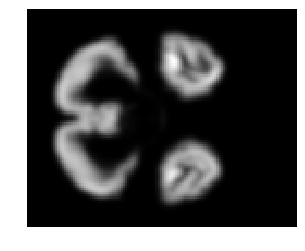

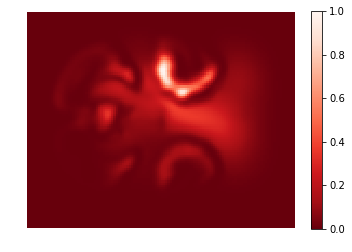

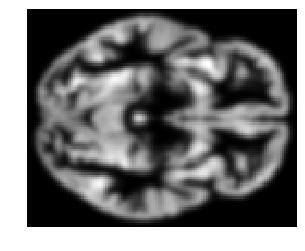

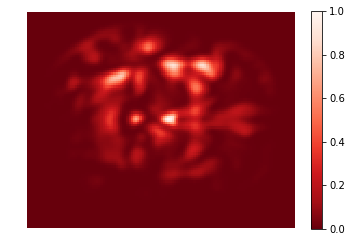

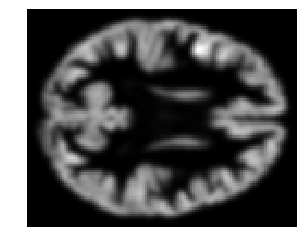

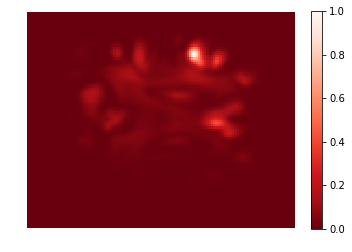

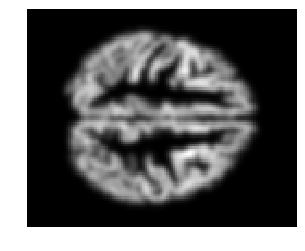

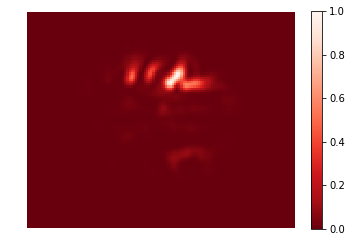

In [59]:
save_and_display(X0, R, old = False)

In [0]:
#for m in range(4):
#  files.download('old_hm_{}.png'.format(m))
#  files.download('old_MRI_{}.png'.format(m))

#for m in range(4):
#  files.download('young_hm_{}.png'.format(m))
#  files.download('young_MRI_{}.png'.format(m))